Задача:
Дан сэмпл данных по фактическому оттоку клиентов из компании за 3 месяца.
По имеющемуся набору данных, необходимо построить модель, которая будет прогнозировать значение целевой переменной 'churn'. Аргументировать выбор модели. 
Подготовить описательный профиль склонного к оттоку клиента, и его отличение от других клиентов.

1. предоброботка
1. однофакторный анализ
1. обучение разных моделей
1. сравнение
1. поиск портрета уходящего клиента (через методы кластеризации)
1. выводы

Автор: Двирник Юлия. 

In [814]:
# импортируем необходимые библиотеки

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pydotplus

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.metrics import roc_auc_score



# Анализ данных и предобработка

In [862]:
# загружаем датасет

data_set = pd.read_csv('churn_train.txt', sep="\t", decimal=',')

# оценим сбалансированнность классов

print('Доля класса 0:', round((len(data_set[data_set['churn'] == 1]) / len(data_set)) * 100), '%')
print('Доля класса 1:', round((len(data_set[data_set['churn'] == 0]) / len(data_set)) * 100), '%')

# классы не сбалансированы 27% и 73%

# смотрим, сколько пропусков в датасете
print('\nпропусков всего: ')
display(data_set.isnull().sum())
# всего один пропуск в одном месте

# Заполняем пропуски средними значениями
data_set['salary_bucket'] = data_set['salary_bucket'].fillna(data_set['salary_bucket'].mean())

# конвертируем фичу 'channel' в бинарный вид
data_set['channel'] = np.where(data_set['channel'] == 'Branch', 1, 0)

# избавляемся от client_id. На первый взгляд это кажется только индексом и у него околонулевая
# кореляция с таргетом. Но прежде проверим одну гипотезу.

data_set['client_id'].nunique()  # gives us 7497
len(data_set)  # gives us 8305

# число уникальных client_id равно 7497, это не совпадает с количеством всех сэмплов (8305).
# они повторяются. Гипотеза, что мы можем из тех клиентов, что участвуют в датасете дважды с 
# с разным таргетом извлечь полезную аналитику очень слабая.
# Если изучить, что из себя представляют разные записи с одинаковым client_id, видно что 
# их стоит рассматривать как отдельный сэмплы, а столбец с client_id можно удалить.
# Например, client_id == 10255 это клиент, вероятно переехавший из региона в Москву, а 10435
# возможно совпадение т.к. у одного и того же клиента возраст разнится на 24 года.
print('\nПримеры совпадений по client_id')
display(data_set[data_set['client_id'] == 10435])
display(data_set[data_set['client_id'] == 10225])

data_set = data_set.drop(columns=['client_id'])

# сделаем фичу 'region' бинарной с помощью one-hot encoding
onehot = pd.get_dummies(data_set[['region']]).astype('int8')

data_set_numeric_only = data_set.drop(columns=['region'])
data_set_numeric = pd.concat([data_set_numeric_only, onehot], axis=1)
print('\n датасет')
data_set_numeric

Доля класса 0: 27 %
Доля класса 1: 73 %

пропусков всего: 


client_id              0
month_number           0
age                    0
lifetime               0
beh_score              0
region                 0
channel                0
avg_transaction_sum    0
total_products         0
deposit                0
is_package             0
salary_bucket          1
churn                  0
dtype: int64


Примеры совпадений по client_id


,client_id,month_number,age,lifetime,beh_score,region,channel,avg_transaction_sum,total_products,deposit,is_package,salary_bucket,churn
1820,10435,1,42,18,2.82,Moscow,0,0,2,0,0,170000.0,0
4047,10435,3,66,17,2.80,Regions,1,343,1,1,0,160000.0,1


,client_id,month_number,age,lifetime,beh_score,region,channel,avg_transaction_sum,total_products,deposit,is_package,salary_bucket,churn
267,10225,1,30,19,2.83,Moscow,1,383,1,0,0,50000.0,0
3533,10225,1,30,16,2.90,Regions,1,329,1,1,0,20000.0,1



 датасет


,month_number,age,lifetime,beh_score,channel,avg_transaction_sum,total_products,deposit,is_package,salary_bucket,churn,region_Moscow,region_Regions,region_Saint-Petersbourgh
0,2,38,21,2.73,0,345,1,1,1,70000.0,0,1,0,0
1,2,30,21,2.80,1,269,1,1,1,30000.0,0,1,0,0
2,1,48,13,2.80,0,327,1,1,1,150000.0,1,0,1,0
3,3,40,15,2.68,0,0,1,1,1,30000.0,0,1,0,0
4,2,20,21,2.88,1,0,1,1,0,190000.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8300,2,74,12,2.81,1,349,1,1,1,160000.0,0,1,0,0
8301,2,32,13,2.78,1,344,1,1,1,180000.0,0,0,1,0
8302,1,34,17,2.74,0,357,1,0,1,120000.0,0,0,0,1
8303,3,42,20,2.66,0,272,3,1,1,190000.0,1,1,0,0


In [868]:
# Посмотрим, как распределены данные по каждой фиче в зависимости от класса.
# Для значений каждой фичи посчитаем доли ушедших и неушедших клиентов, т.е. таргет.
# Визуализируем всё на графиках для наглядности.
# Этот метод мощнее чем кореляция, т.к. зависимость может быть не только линейной

# Разделим датасет на два по классам
data_set_0 = data_set_numeric[data_set_numeric['churn'] == 0]
data_set_1 = data_set_numeric[data_set_numeric['churn'] == 1]

# Функция, которая будет строить графики
def prob(df, feature, target, bars=False):
    data_set_0 = df[df[target] == 0]
    data_set_1 = df[df[target] == 1] # клиенты уходят
    
    feature_0 = np.asarray(data_set_0[feature])
    general_counts = len(feature_0) # кол-во клиентов, которые остались
    unique, counts = np.unique(feature_0, return_counts= True) # кол-во клиентов для каждого значения фичи
    prob_0 = np.asarray((unique, counts/general_counts)) # array (feature_val, 

    prob_1 = np.asarray(data_set_1[feature])
    general_counts = len(prob_1) # кол-во клиентов, которые ушли
    unique, counts = np.unique(prob_1, return_counts= True)
    prob_1 = np.asarray((unique, counts/general_counts))

    if bars:
        plt.bar(prob_0[0], prob_0[1], color='g')
        plt.bar(prob_1[0], prob_1[1], color='r', alpha=0.5)
    else:
        plt.plot(prob_0[0], prob_0[1], 'g', prob_1[0], prob_1[1], 'r')
    plt.show()

# Зеленым будет показываться диаграммы и графики для таргет 0 (клиент не ушел)
# Красным - таргет 1 (клиент ушел)

## month_number

PearsonRResult(statistic=0.013185460510945232, pvalue=0.2295628325745923)


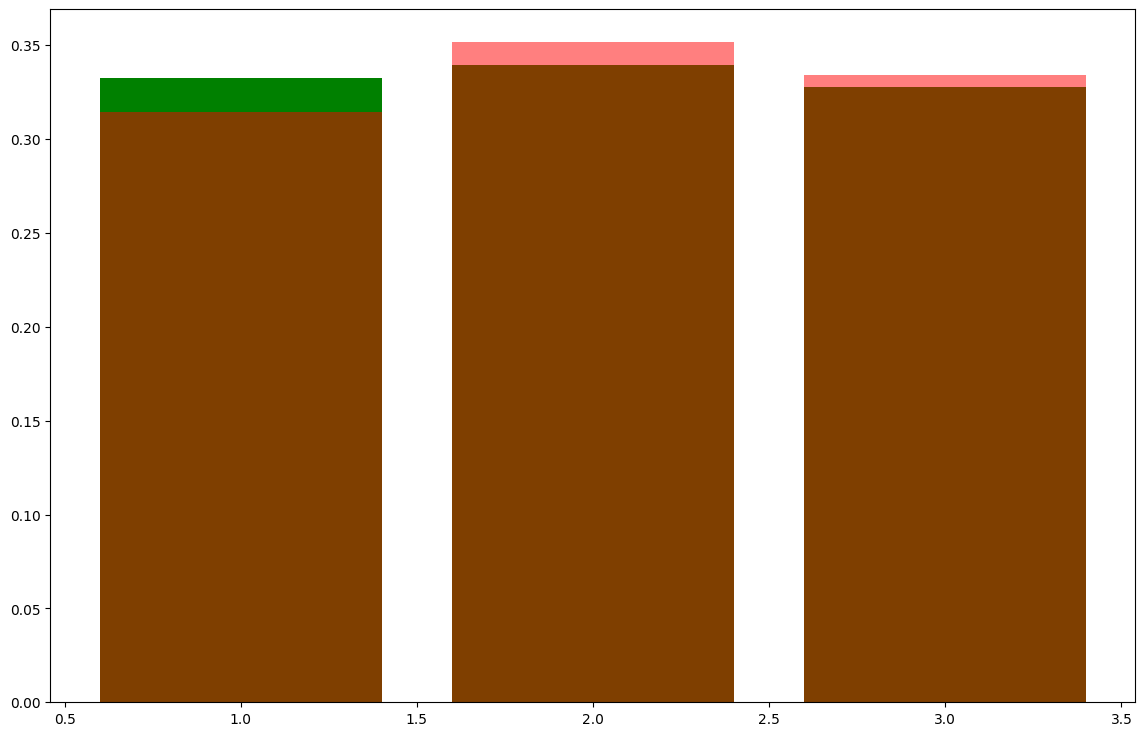

In [869]:
cor = pearsonr(data_set_numeric['churn'], data_set_numeric['month_number'])
print(cor)

prob(data_set_numeric, 'month_number', 'churn', bars=1)

# корреляции нет, диаграмма имеет незначительные отличия

## age

PearsonRResult(statistic=0.2125261819913917, pvalue=1.913241798846766e-85)


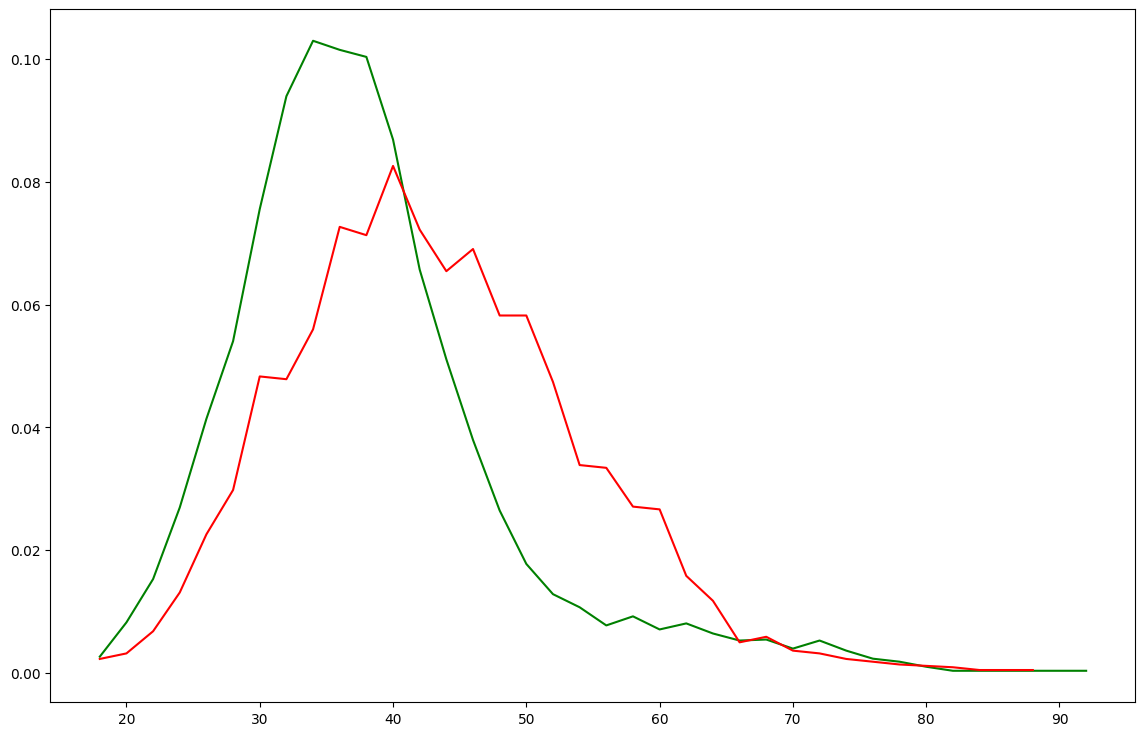

In [870]:
cor = pearsonr(data_set_numeric['churn'], data_set_numeric['age'])
print(cor)

prob(data_set_numeric, 'age', 'churn')

# есть статистически значимая корреляция, есть отличия в графиках
# c увеличением возраста (с 42) клиент вероятнее уходит чем в среднем по датасету, после 65 различий нет

## lifetime

PearsonRResult(statistic=-0.002690215092569381, pvalue=0.8063576242757111)


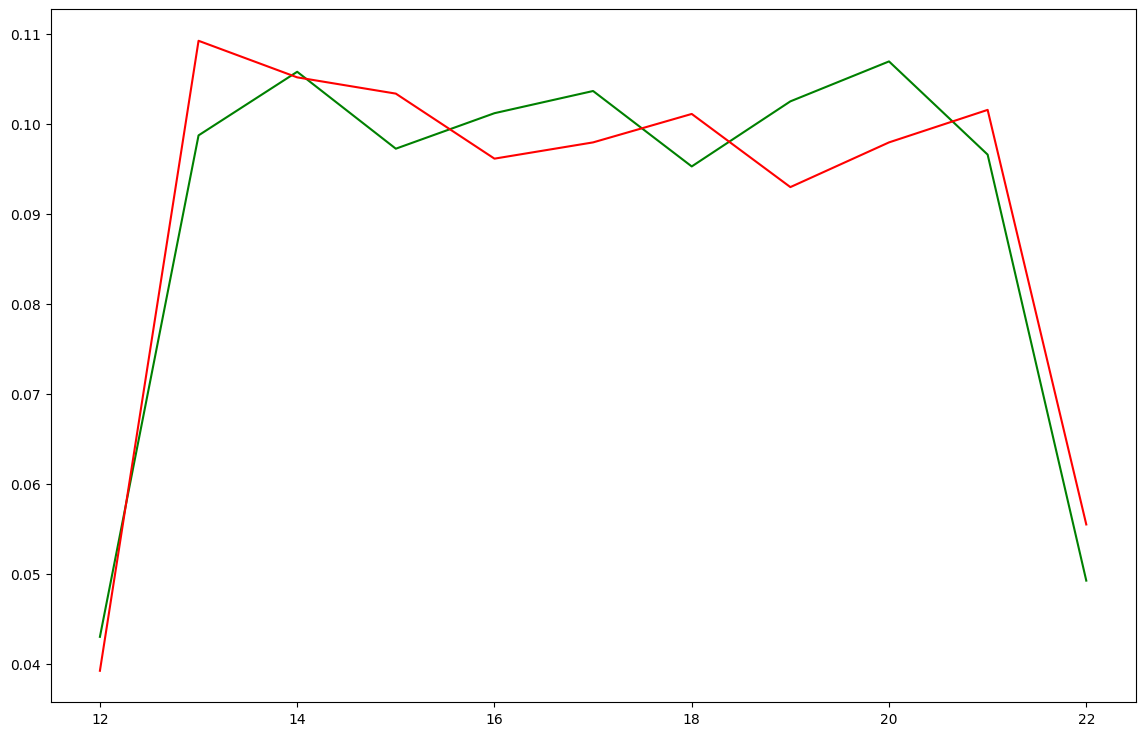

In [819]:
cor = pearsonr(data_set_numeric['churn'], data_set_numeric['lifetime'])
print(cor)

prob(data_set_numeric, 'lifetime', 'churn')

# корреляции нет, графики повторяют друг друга, но есть некоторые интересные места
# возможно, сильный алгоритм сможет вытащить оттуда что-нибудь

## beh_score

PearsonRResult(statistic=-0.002690215092569381, pvalue=0.8063576242757111)


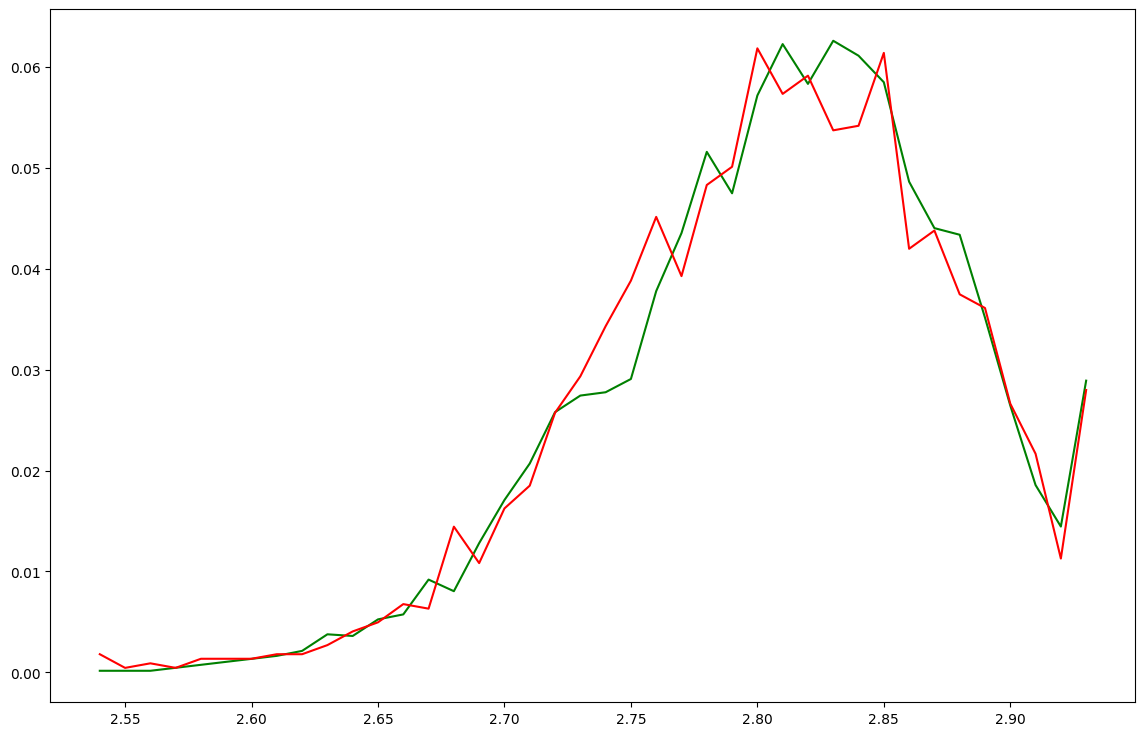

In [820]:
cor = pearsonr(data_set_numeric['churn'], data_set_numeric['lifetime'])
print(cor)

prob(data_set_numeric, 'beh_score', 'churn')

# корреляции нет, графики примерно повторяют друг друга, но есть некоторые интересные места
# возможно, сильный алгоритм сможет вытащить оттуда что-нибудь

## region_Moscow

PearsonRResult(statistic=-0.061961541575085065, pvalue=1.5928946283496934e-08)


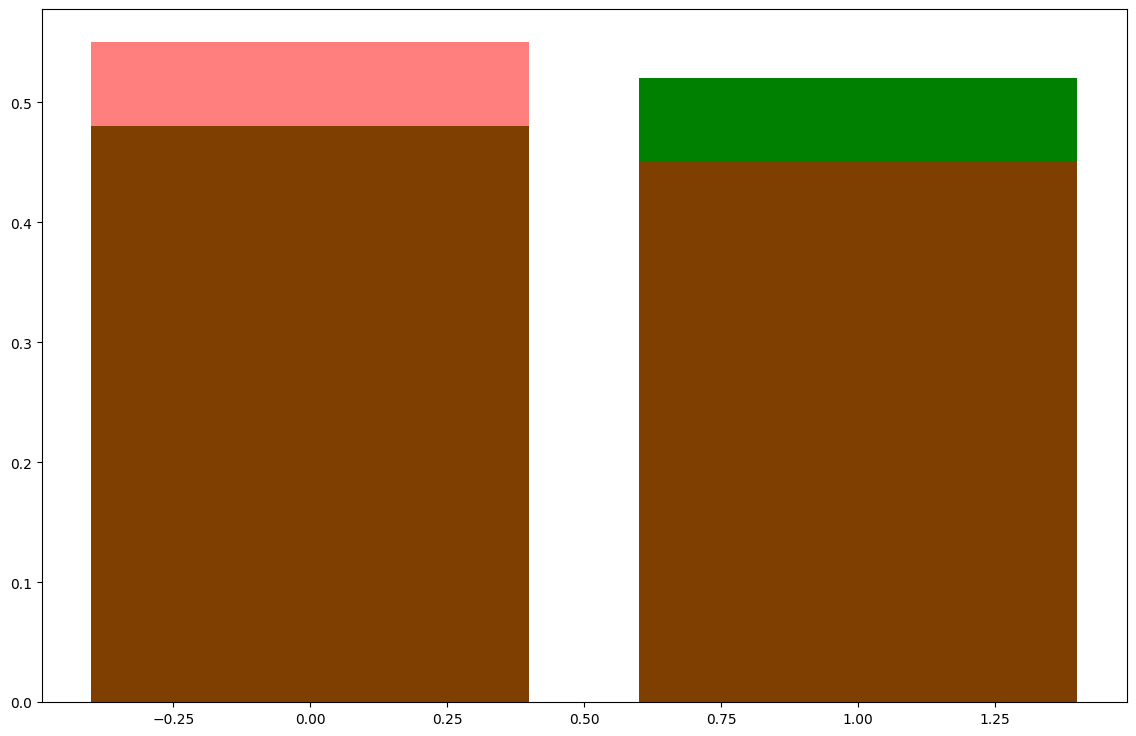

In [821]:
cor = pearsonr(data_set_numeric['churn'], data_set_numeric['region_Moscow'])
print(cor)

prob(data_set_numeric, 'region_Moscow', 'churn', bars=True)

# есть статистически значимая корреляция, есть отличия в диаграмме

## region_Regions

PearsonRResult(statistic=0.11887047314708786, pvalue=1.6054484237987918e-27)


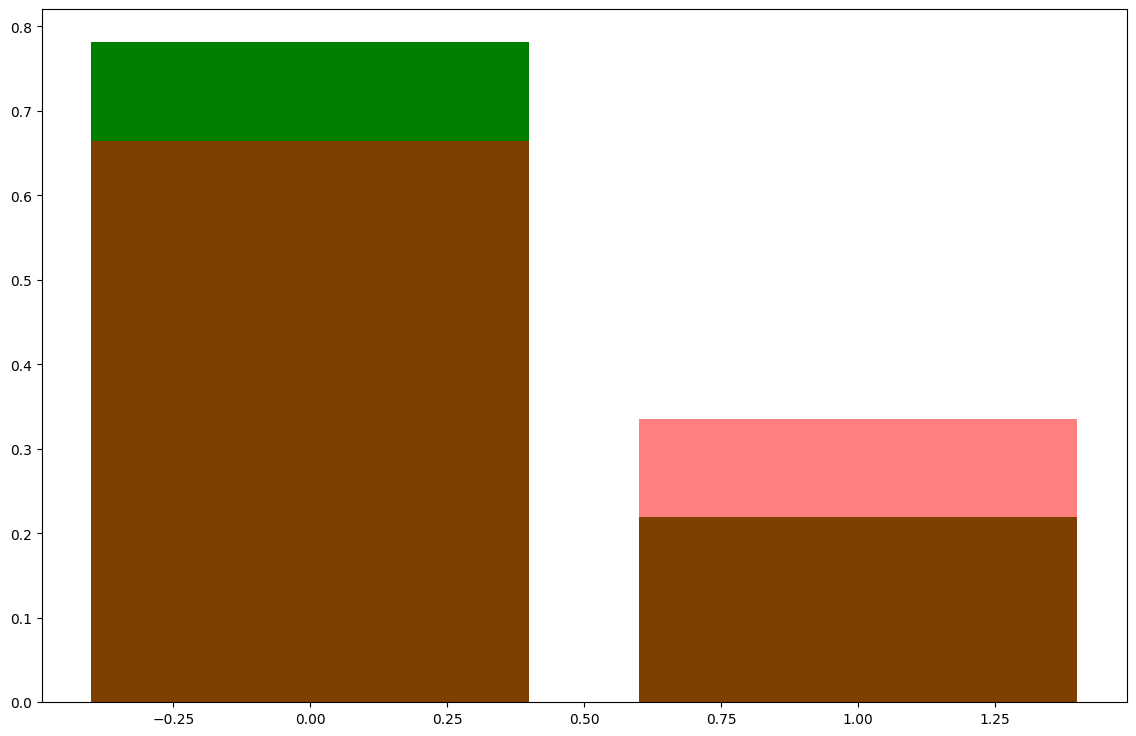

In [822]:
cor = pearsonr(data_set_numeric['churn'], data_set_numeric['region_Regions'])
print(cor)

prob(data_set_numeric, 'region_Regions', 'churn', bars=True)

# есть статистически значимая, но не сильная корреляция, есть отличия в диаграмме

## region_Saint-Petersbourgh

PearsonRResult(statistic=-0.047397158690925686, pvalue=1.552072654789474e-05)


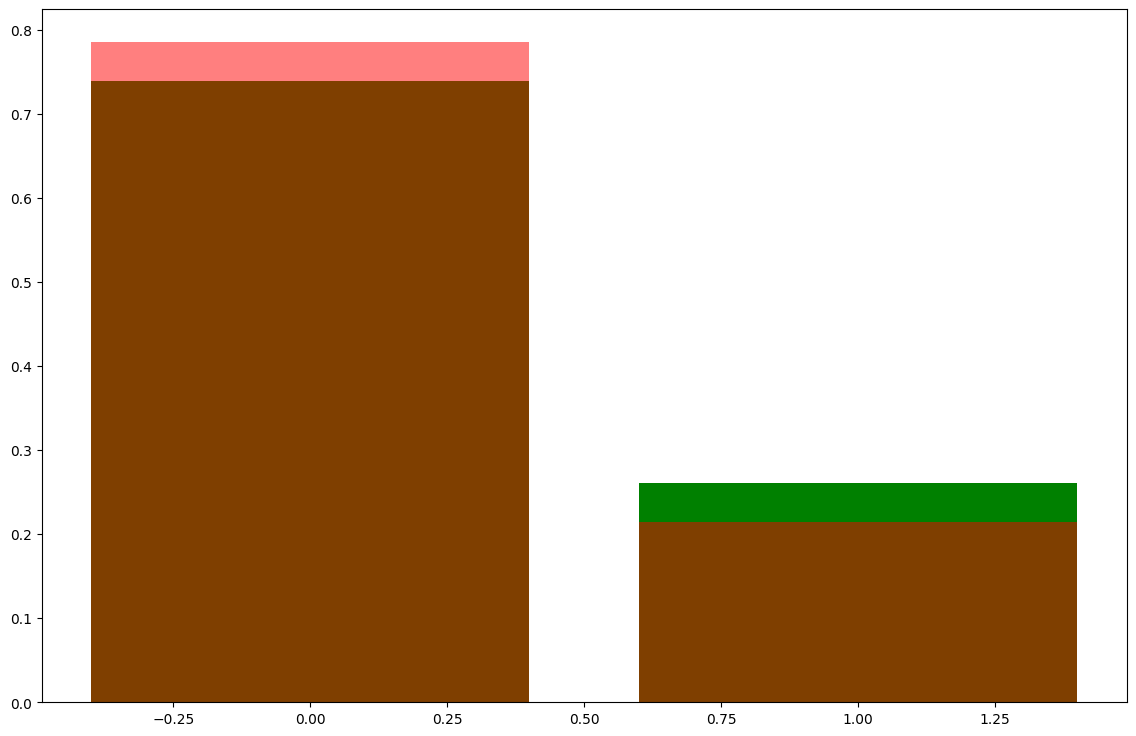

In [823]:
cor = pearsonr(data_set_numeric['churn'], data_set_numeric['region_Saint-Petersbourgh'])
print(cor)

prob(data_set_numeric, 'region_Saint-Petersbourgh', 'churn', bars=True)

# есть статистически значимая, но не сильная корреляция, есть отличия в диаграмме

## channel

PearsonRResult(statistic=0.0746924901522689, pvalue=9.403079871723201e-12)


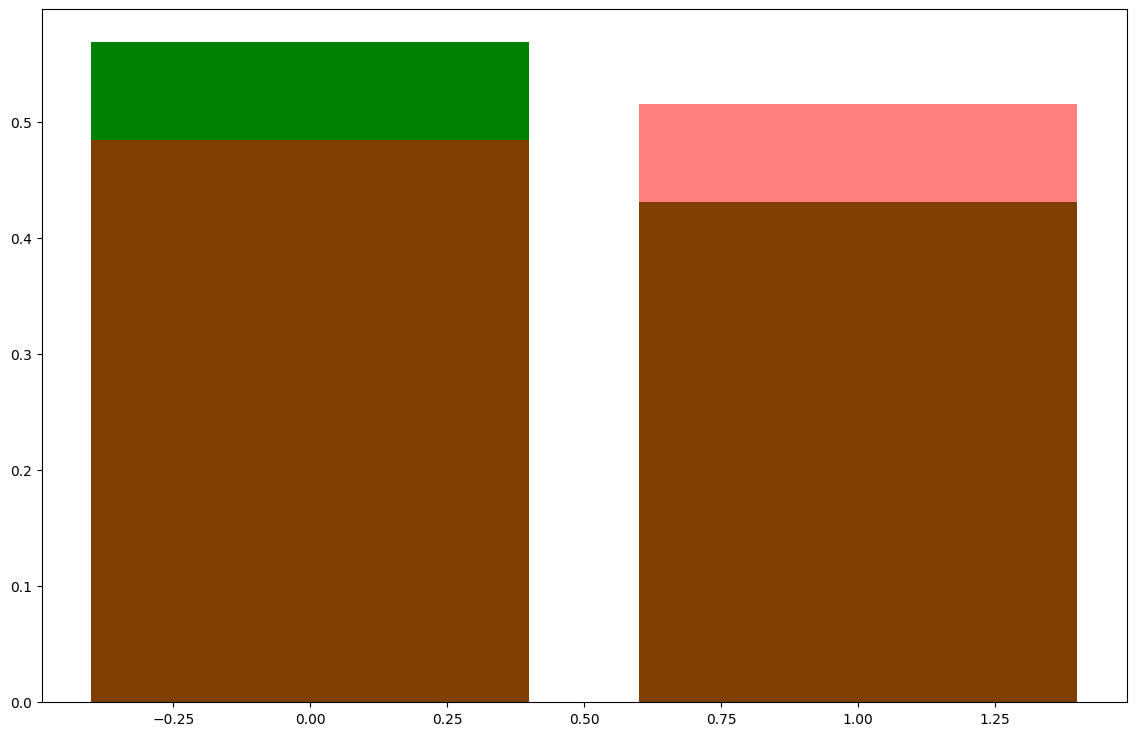

In [824]:
cor = pearsonr(data_set_numeric['churn'], data_set_numeric['channel'])
print(cor)

prob(data_set_numeric, 'channel', 'churn', bars=True)

# есть статистически значимая, но не сильная корреляция, есть отличия в диаграмме
# уходят скорее те, кто оформили в отделении

## avg_transaction_sum

PearsonRResult(statistic=0.08944085340638405, pvalue=3.186605420441981e-16)


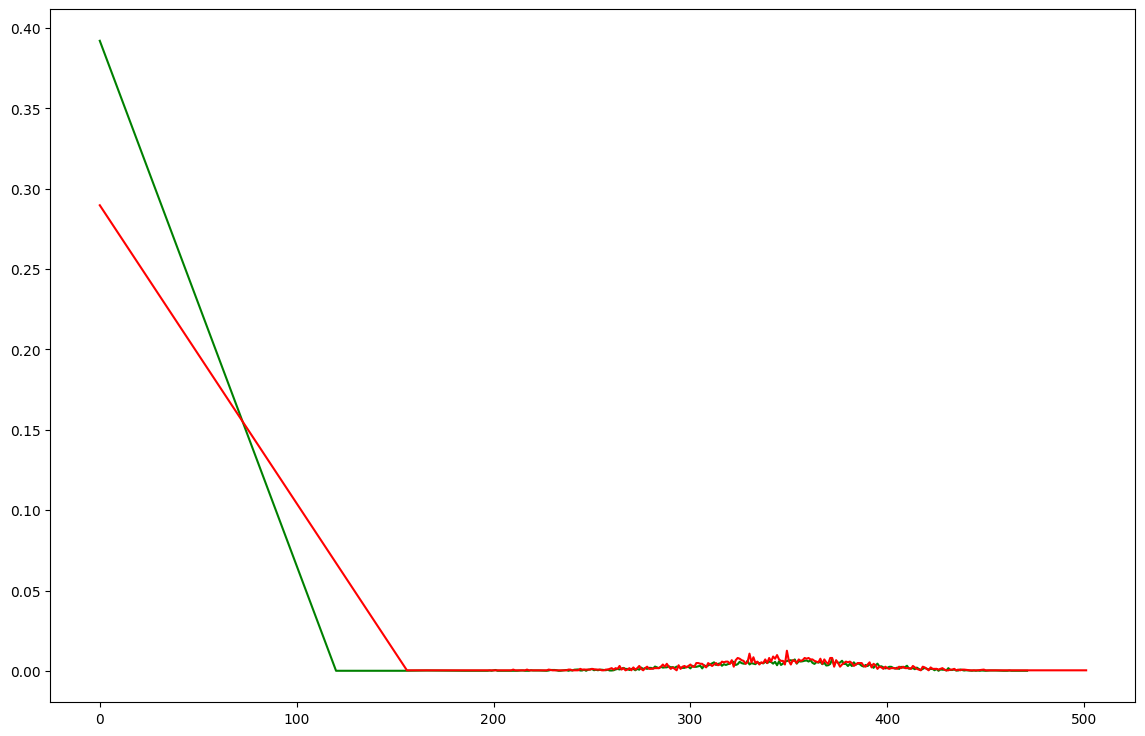

PearsonRResult(statistic=-0.09400740063671917, pvalue=9.100438361287064e-18)
PearsonRResult(statistic=-0.9773389084977968, pvalue=0.0)


In [825]:
cor_1 = pearsonr(data_set_numeric['churn'], data_set_numeric['avg_transaction_sum'])
print(cor_1)

prob(data_set_numeric, 'avg_transaction_sum', 'churn')

# есть статистически значимая, но не сильная корреляция
# интересный график, левая его часть показывает различия, в то время как правая показывает примерно одну
# линию раcпределения. Выделим отсюда полезный признак и добавить к датасету как 'null_avg_trans_sum'.
# Этот признак показывает чуть большую линейную зависимость, чем просто 'avg_transaction_sum'
# Эти два признака очень коррелируют между собой, будем иметь это ввиду, если будет использовать методы которым это важно.

data_set_numeric['null_avg_trans_sum'] = np.where(data_set_numeric['avg_transaction_sum'] == 0, 1, 0)

cor_2 = pearsonr(data_set_numeric['churn'], data_set_numeric['null_avg_trans_sum'])
print(cor_2)

cor_3 = pearsonr(data_set_numeric['avg_transaction_sum'], data_set_numeric['null_avg_trans_sum'])
print(cor_3)


## total_products

PearsonRResult(statistic=-0.033465421127745615, pvalue=0.0022872071927084667)


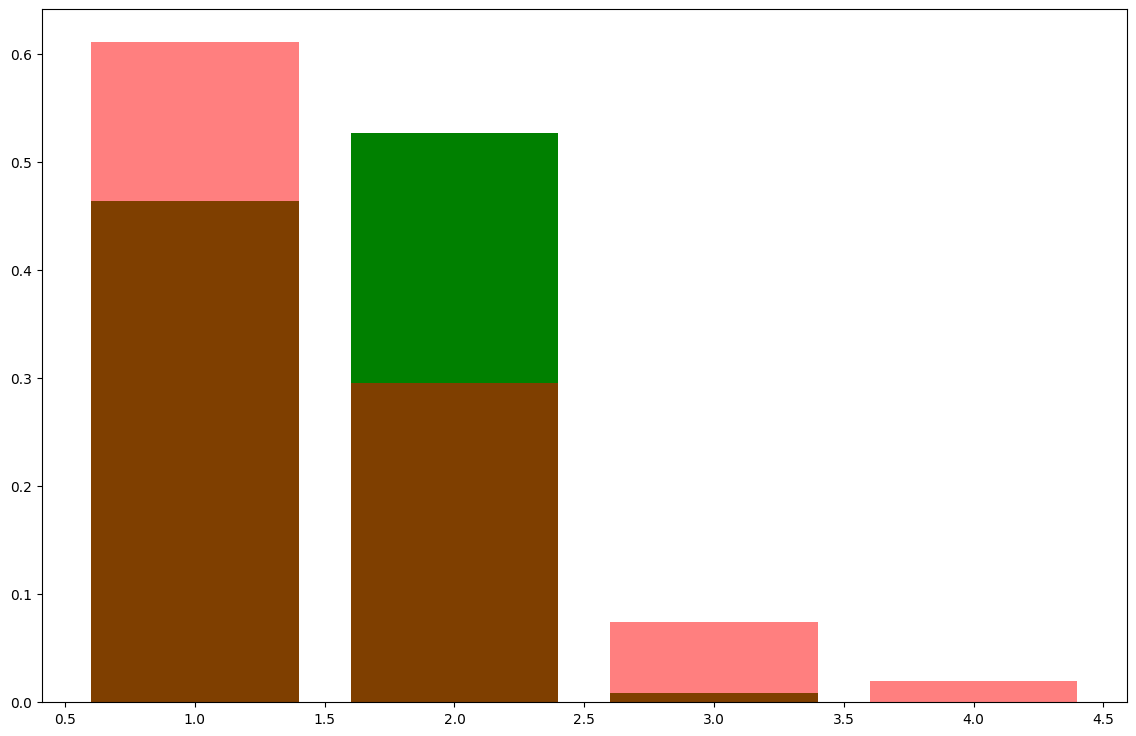

In [826]:
cor = pearsonr(data_set_numeric['churn'], data_set_numeric['total_products'])
print(cor)

prob(data_set_numeric, 'total_products', 'churn', bars=True)

# есть статистически значимая, но не сильная корреляция, есть отличия в диаграмме

## deposit

PearsonRResult(statistic=-0.00366101507671353, pvalue=0.7386922163263515)


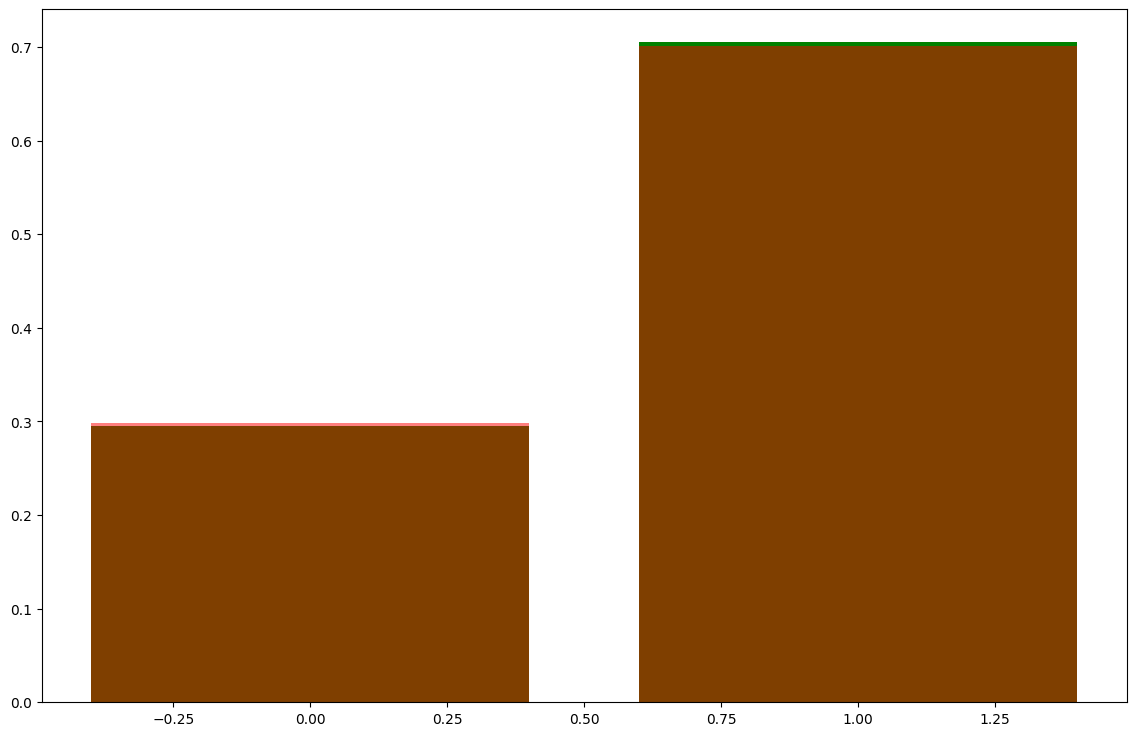

In [827]:
cor = pearsonr(data_set_numeric['churn'], data_set_numeric['deposit'])
print(cor)

prob(data_set_numeric, 'deposit', 'churn', bars=True)

# корреляции нет, диаграмма практически не имеет отличий
# признак не информативный

## is_package

PearsonRResult(statistic=-0.11133605574813693, pvalue=2.5280177013960963e-24)


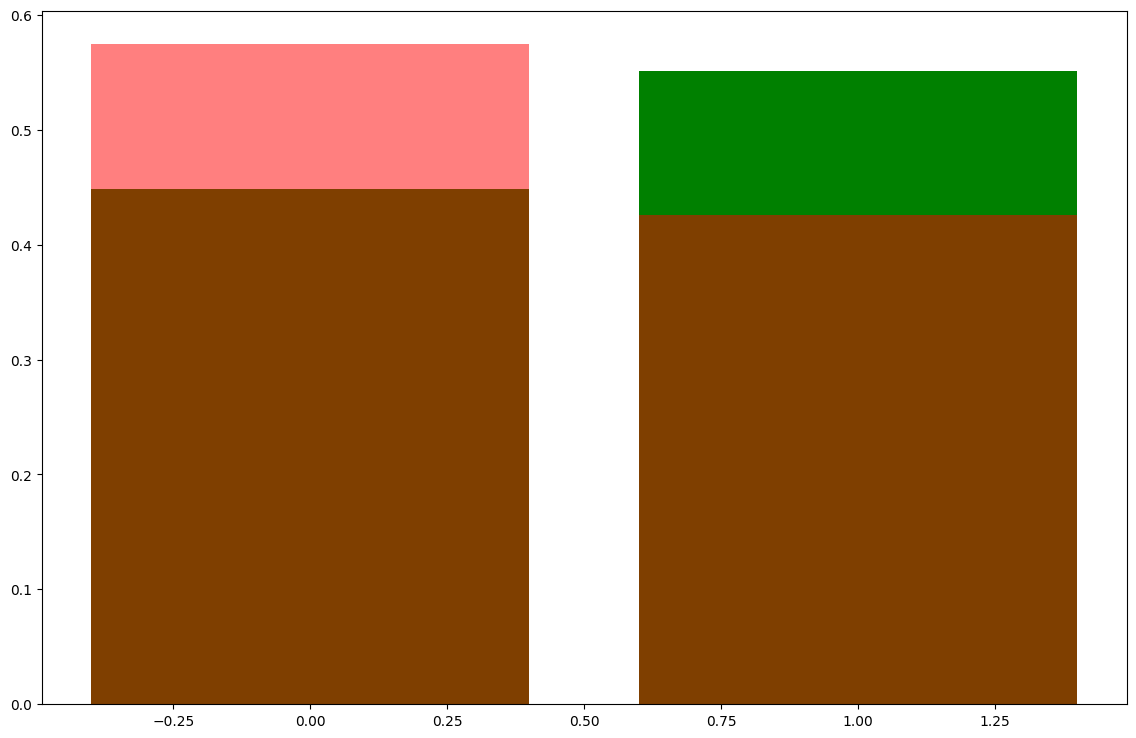

In [828]:
cor = pearsonr(data_set_numeric['churn'], data_set_numeric['is_package'])
print(cor)

prob(data_set_numeric, 'is_package', 'churn', bars=True)

# есть статистически значимая корреляция, есть отличия в диаграмме

## salary_bucket

PearsonRResult(statistic=0.0015271837340879127, pvalue=0.8893283838107261)


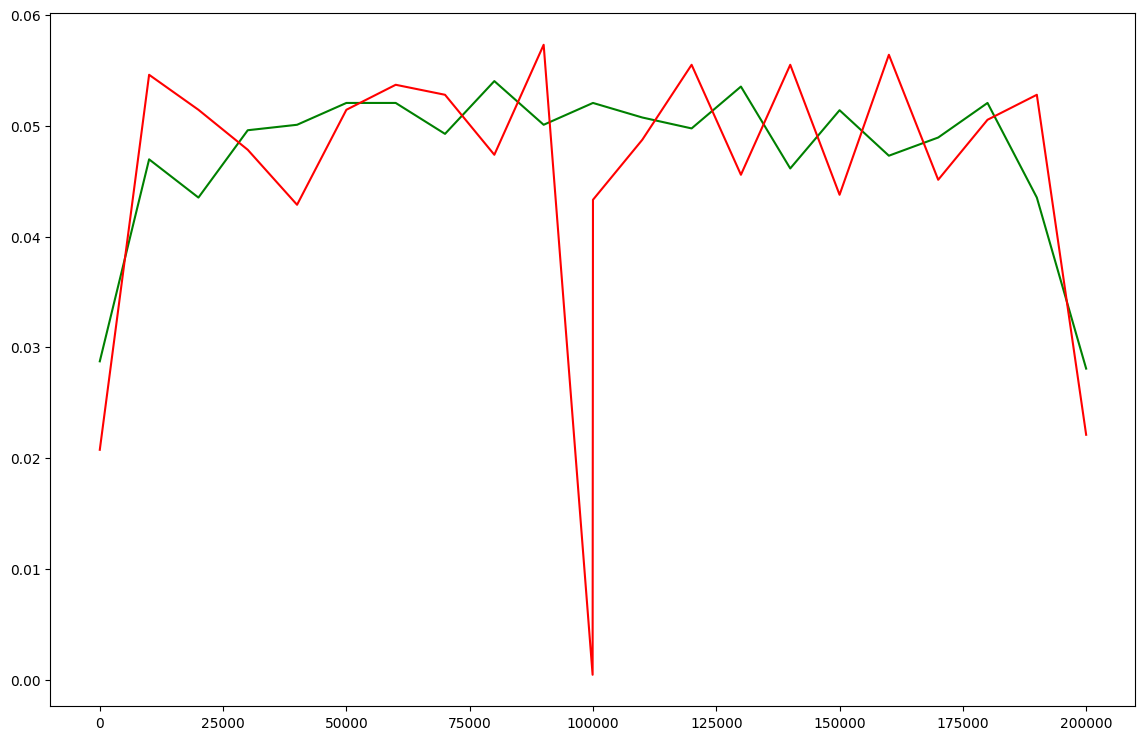

In [829]:
cor = pearsonr(data_set_numeric['churn'], data_set_numeric['salary_bucket'])
print(cor)

prob(data_set_numeric, 'salary_bucket', 'churn')

# корреляции нет, графики повторяют друг друга, но есть некоторые интересные места (например, провал в 100000)
# возможно, сильный алгоритм сможет вытащить оттуда что-нибудь
# можно отдельно вытащить фичу salary_bucket == 100000, но в данной работе этого не будем делать.

## корреляционная матрица  

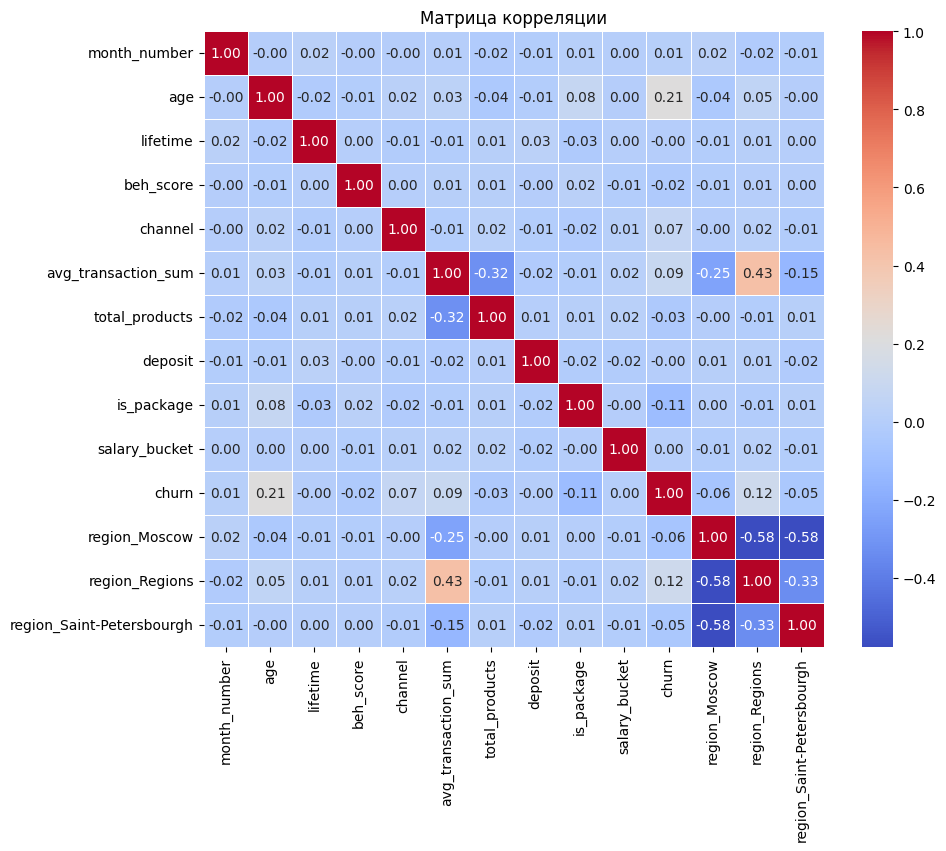

In [830]:
# Построим матрицу корреляции между признаками
correlation_matrix = data_set_numeric.corr()

# Визуализируем матрицу корреляции с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

# На целевую переменную большее влияние оказывает 'age', 'region_Regions', 'is_package', 'avg_transaction_sum',
# 'channel', 'region_Moscow', 'region_Saint-Petersbourgh'

# При этом с признаком 'avg_transaction_sum' сильно коррелируют 'total_products', 'region_*'

# И, конечно, все признаки из колонки region - 'region_Regions', 'region_Moscow', 'region_Saint-Petersbourgh'
# тоже коррелируют между собой т.к. порождены одной переменной

# Подбор модели для обучения

## Подготовка данных

In [873]:
# Разделим данные на train и testи

X_main = data_set_numeric.drop(['churn'], axis=1)
y_main = data_set_numeric['churn']

X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=0.2, stratify=y_main, random_state=42)

## Выбор моделей для обучения

In [879]:
# Для выбора лучшей модели обучим на нашей выборке несколько из них, и выберем ту, 
# которая будет лучше по показателям
# У некоторых моделей шиперпараметры немного подобраны руками

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

classifiers = {
    "logreg": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(7),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(max_depth=6, n_estimators=150, max_features=15),
    "Neural Net": MLPClassifier(activation='logistic', learning_rate_init=0.01, hidden_layer_sizes=30, max_iter=10000),
    "AdaBoost":     AdaBoostClassifier(),
    "Naive Bayes":     GaussianNB(),
    "QDA":     QuadraticDiscriminantAnalysis(),
    'XGboost': XGBClassifier(method='hist', learning_rate=0.1, max_depth=5, n_estimators=10),
}


## Выбор метрики для оценки

ROC for logreg 0.656
ROC for Nearest Neighbors 0.650
ROC for Decision Tree 0.715
ROC for Random Forest 0.729
ROC for Neural Net 0.678
ROC for AdaBoost 0.709
ROC for Naive Bayes 0.663
ROC for QDA 0.647
[23:14:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "method" } are not used.

ROC for XGboost 0.730


c:\users\julia\miniconda\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


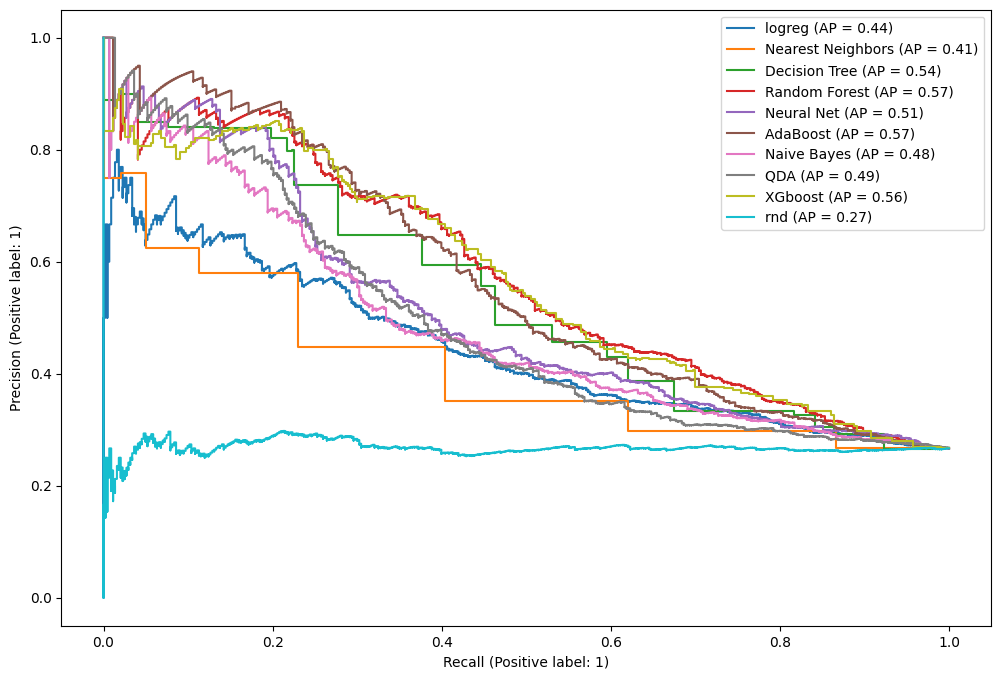

In [939]:
# Посмтроим график Average Precision, посчитаем ROC-AUC

plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots()

for name, clf in classifiers.items():
    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    y_predict = clf.predict_proba(X_test)
    y_predict = y_predict[:, 1]
    roc_val = roc_auc_score(y_test, y_predict)
    print(f'ROC for {name} {roc_val:.3f}')
    PrecisionRecallDisplay.from_predictions(y_test, y_predict, name=name, ax=ax)
    
    
y_predict = np.random.uniform(0,1, y_test.shape)
PrecisionRecallDisplay.from_predictions(y_test, y_predict, name='rnd', ax=ax)

ax.legend()

## Лучшая модель для данной задачи

# Портрет уходящего клиента

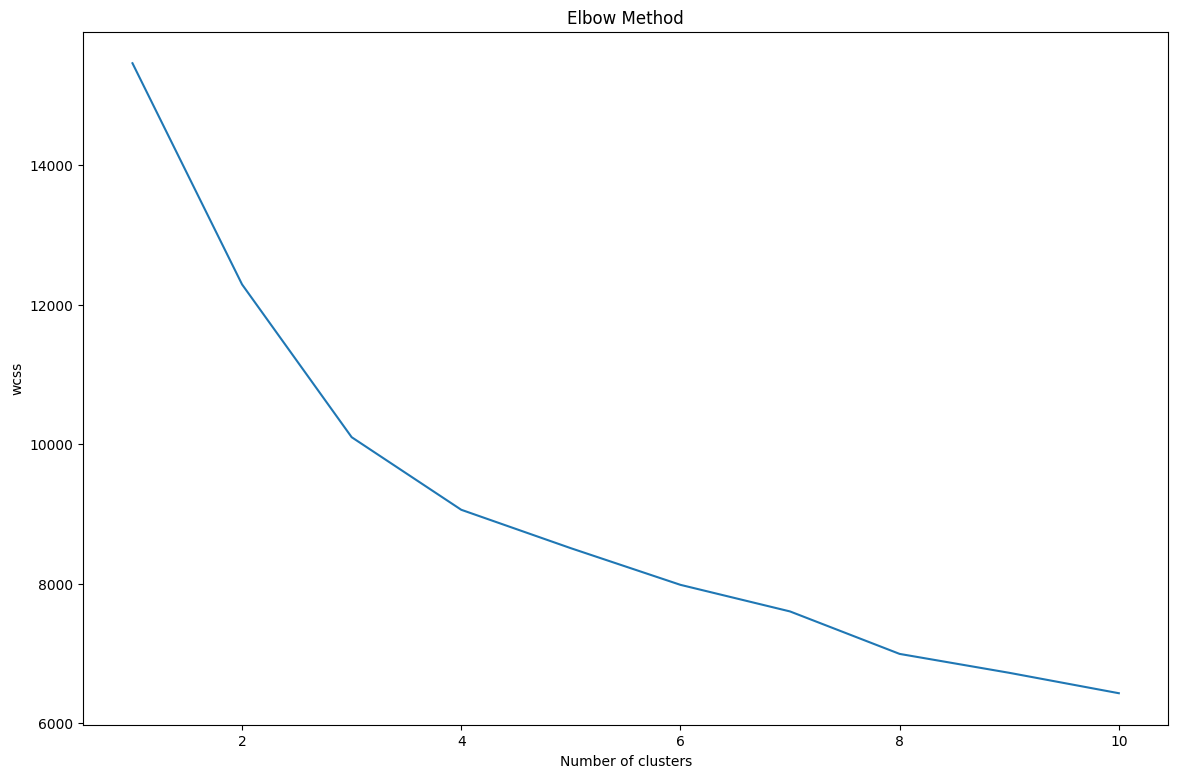

In [886]:
from sklearn.cluster import KMeans


# нормируем данные
X_main_norm = X_main.iloc[:,0:len(X_main.columns)].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0)

# строим график, зависисмость общей суммы квадратов расстояний внутри кластера от количества кластеров 
wcss = []
n_clusters = 11
for i in range(1,n_clusters):
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X_main_norm)
    wcss.append(km.inertia_)
plt.plot(range(1,n_clusters),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show() 

# По графику выбираем количество кластеров

In [897]:
# Разобьем нашу выборку на кластеры и посмотрим, как в них распределны уходящие клиенты

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
y_means = kmeans.fit_predict(X_main_norm)

kmeans.cluster_centers_
X_kmeans = data_set_numeric.copy()
X_kmeans['cluster'] = y_means

for i in range(n_clusters):
    amount_0 = len(X_kmeans[(X_kmeans['cluster'] == i) & (X_kmeans['churn'] == 0)])
    amount_1 = len(X_kmeans[(X_kmeans['cluster'] == i) & (X_kmeans['churn'] == 1)])
    
    print('For', i, 'cluster the amount of churn clients = ', amount_1/(amount_0 + amount_1))


For 0 cluster the amount of churn clients =  0.1972286374133949
For 1 cluster the amount of churn clients =  0.23039690222652467
For 2 cluster the amount of churn clients =  0.3578998073217726
For 3 cluster the amount of churn clients =  0.2852852852852853


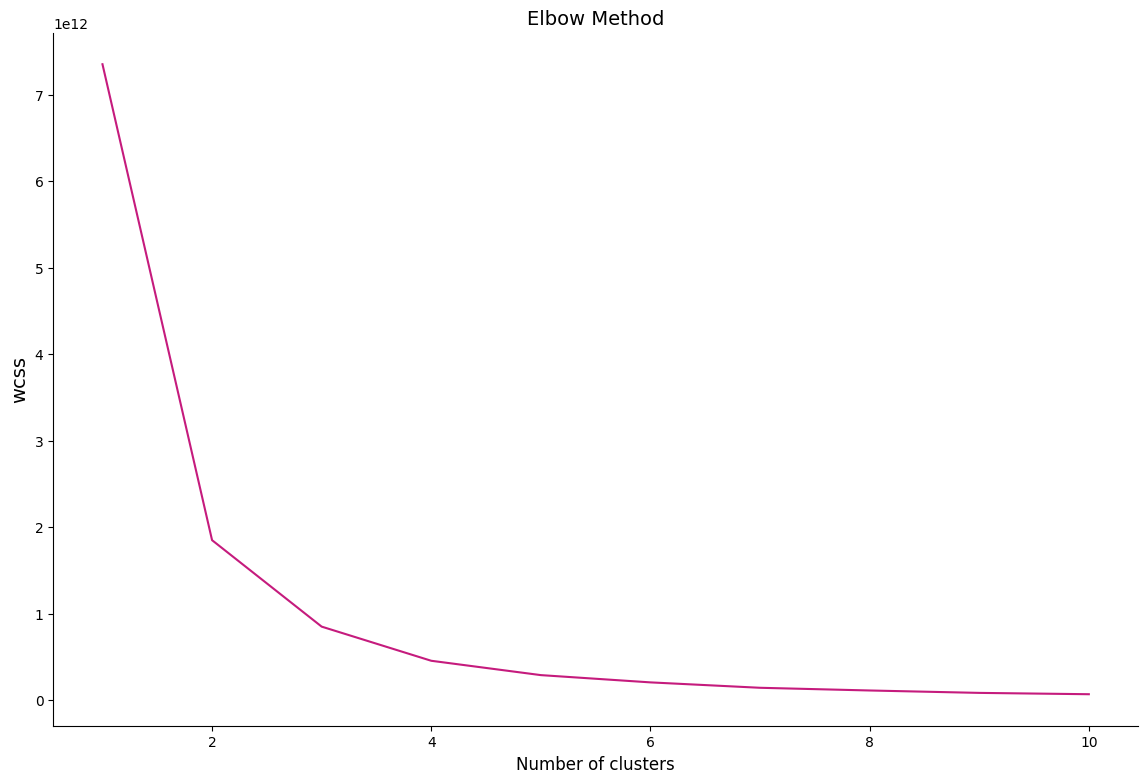

In [846]:
# Видно, что в каждом кластере уходящие клиенты распределны примерно также, как и в исходной выборке.
# Для нас это плохо, т.к. нужного кластера не появилось

# Попробуем сделать то же самое, только сначала построим кластеры, учитывая только подвыборку с уходящими 
# клиентами, а затем, используя эти же центры, попробуем создать полнеценные кластеры, добавив туда подвыборку
# остающихся клиентов

X_1 = data_set_numeric.copy()
X_1 = X_1[X_1['churn'] == 1]

y_1 = X_1['churn']
X_1 = X_1.drop(columns=['churn'])

# сохраним на будущее значения для каждого стобца min и max, чтобы потом иметь возможность вернуться 
# от нормированных данных к данным обычного вида
columns_min_max = []
for i in range(len(X_1.columns)):
    max_ = X_1.iloc[:, i].max()
    min_ = X_1.iloc[:, i].min()
    columns_min_max.append((min_, max_))
X_1_norm = X_1.iloc[:,0:len(X_1.columns)].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0)

# Посмотрим на число кластеров в этом случае
wcss = []
for i in range(1,11):
    km = KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_1)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss, c="#c51b7d")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title('Elbow Method', size=14)
plt.xlabel('Number of clusters', size=12)
plt.ylabel('wcss', size=14)
plt.show() 

# График практически такой же, оптимальное количество кластеров - 8 

In [905]:
n_clusters=4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0)
kmeans.fit(X_1_norm)
clusters_1 = kmeans.predict(X_1_norm)

cluster_centers = kmeans.cluster_centers_

X_0 = data_set_numeric.copy()
X_0 = X_0[X_0['churn'] == 0]
y_0 = X_0['churn']
X_0 = X_0.drop(columns=['churn'])

X_0_norm = X_0.iloc[:,0:len(X_0.columns)].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0)
clusters_0 = kmeans.predict(X_0_norm)

for i in range(n_clusters):
    amount_0 = np.sum(clusters_0==i)
    amount_1 = np.sum(clusters_1==i)
    
    print('For', i, 'cluster the amount of churn clients = ', amount_1/(amount_0 + amount_1))

most_churn_cluster = cluster_centers[1]
most_churn_cluster_center = []
for i in range(len(most_churn_cluster)):
    min_, max_ = columns_min_max[i]
    most_churn_cluster_center.append(most_churn_cluster[i] * (max_ - min_) + min_)
    

lst = X_0.columns.tolist() 

For 0 cluster the amount of churn clients =  0.2086994727592267
For 1 cluster the amount of churn clients =  0.3578998073217726
For 2 cluster the amount of churn clients =  0.23039690222652467
For 3 cluster the amount of churn clients =  0.2766295707472178


In [906]:


for i in range(len(lst)):
    print('feature {} with value {:.2f}'.format(lst[i], worst_cluster_center[i]))

# Кластер, который подвержен уходу больше всего - люди с 

feature month_number with value 1.95
feature age with value 45.29
feature lifetime with value 17.13
feature beh_score with value 2.81
feature channel with value 1.00
feature avg_transaction_sum with value 345.66
feature total_products with value 1.47
feature deposit with value 0.72
feature is_package with value -0.00
feature salary_bucket with value 98000.00
feature region_Moscow with value 0.00
feature region_Regions with value 1.00
feature region_Saint-Petersbourgh with value -0.00


In [938]:
not_churn_cluster = cluster_centers[0]
not_churn_cluster_center = []
for i in range(len(not_churn_cluster)):
    min_, max_ = columns_min_max[i]
    not_churn_cluster_center.append(not_churn_cluster[i] * (max_ - min_) + min_)
    
print('feature, \t\t\t not_churn_cluster\t most_churn_cluster')

for i in range(len(lst)):
    feature_name = lst[i]
    spacer = ' '*(30 - len(feature_name))
    print(' {} {} {:.2f} \t\t\t {:.2f}'.format(feature_name, spacer, not_churn_cluster_center[i], worst_cluster_center[i]))

feature, 			 not_churn_cluster	 most_churn_cluster
 month_number                    2.03 			 1.95
 age                             42.60 			 45.29
 lifetime                        17.08 			 17.13
 beh_score                       2.80 			 2.81
 channel                         0.00 			 1.00
 avg_transaction_sum             198.02 			 345.66
 total_products                  1.50 			 1.47
 deposit                         0.73 			 0.72
 is_package                      0.43 			 -0.00
 salary_bucket                   100400.00 			 98000.00
 region_Moscow                   1.00 			 0.00
 region_Regions                  0.00 			 1.00
 region_Saint-Petersbourgh       0.00 			 -0.00


различия по центрам кластеров не всегда есть.
уходящий клиент:
- имеет немного больше возраст
- оформлялся в отделении, а не онлайн
- имеет в среднем выше сумму транзакций (помним, что вообще много клиентов с нулевыми транзакциями)
- не имеет 'package', видимо пакетного предложения
- живет в регионах, не в Москве (Спб - не влияет)

+ ! стоит отметить, что возможно этого метода недостаточно чтобы хорошо кластеризовать. Вероятно уходящие распределены во множестве мест в признаковом пространстве, и нужно рассматривать очень много кластеров, либо более сложные зависимости, как например классификаторы выше.

# Выводы:
- Данные сложные, похожи на реальные, классы перемешаны между собой.
- Мной показано, что лучшие классификаторы -- ансамбли на деревьях дают не более 0.58 mAP/0.72 ROC AUC. 
- С портретом уходящего клиента получилась небольшая аналитика, но требует больше времени и других методов (у меня были одни выходные).
- Для улучшения моделей нужно больше признаков, т.к. текущих недостаточно для надежного разделения.